# Projet Greedy Algorithm, NAVARRE Victor CACHERA Alexandre

In [12]:
import sys
print(sys.prefix)


c:\Users\NAVARRE Victor\anaconda3\envs\apprentissage_profond


## Modules

In [13]:
#Importation des librairies

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize

## Données 

In [14]:
# Premier test
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 1000)
F1 = [np.sin(k * t) for k in K]

# Deuxième test 

## Algorithmes Gloutons

### Fonctions de base 

In [15]:
def proj(f, Vn):

    V = np.column_stack(Vn) 
    coeffs, _, _, _ = np.linalg.lstsq(V, f, rcond=None)
    proj = V @ coeffs
    return proj

#Si la première méthode ne fonctionne pas :
def proj2(f, V):
    """Projection sur V pour la norme L1 (approchée via optimisation)."""
    A = np.column_stack(V)
    def loss(x):
        return np.linalg.norm(A @ x - f, ord=1)
    res = minimize(loss, np.zeros(len(V)))
    return A @ res.x

def dist(f,Vn):
    return(np.linalg.norm(f-proj(f,Vn)))

### Algorithme Strong Greedy

In [16]:
def stronggreedy(F, n):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)           
    Sigma.append(np.linalg.norm(f0))

    for i in range(n):
        id_f = np.argmax([dist(f, Vn) for f in F]) 
        f = F[id_f]
        Sigma.append(dist(f,Vn))
        Vn.append(f)            
    
    return Vn, Sigma

### Algorithme Weak Greedy

On commence par décrire l'Algorithme Greedy faible pour les n-withd, on réalise une implémentation récursive

In [17]:
def weakgreedy(F, gamma, n, sample_size):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)          
    Sigma.append(np.linalg.norm(f0))
    
    for i in range(n):
        
        # On cherche une approximation de la distance maximale
        sample_indices = np.random.choice(len(F1), size=sample_size, replace=False)
        sample_distances = []
        
        for idx in sample_indices:
            f = F[idx]
            sample_distances.append(dist(f,Vn))

        current_max = np.max(sample_distances)

        for f in F:   #ici premier choisi, sinon les tirer tous et choisir &léatoirement parmi les bons candidats
            if dist(f,Vn) >= gamma*current_max:
                Sigma.append(dist(f,Vn))  #La ça serait pas plutôt Sigma.append(dist(f,Vn)) parce que on vérifie déjà le critère? A  méditer.  Sigma.append(np.max([dist(f,Vn) for f in F]))
                Vn.append(f)  
                break
    return Vn, Sigma


### Algorithme Weak Weak Greedy c'est de la merde je vais l'enlever

On propose une autre version de l'algorithme glouton faible. Pour réalise l'hypothèse que la distance maximale est proche de celle précédement calculé par l'algorithme faible. Cette méthode ne fonctionne que pour des gamma strictement inférieur à 1. Nous n'avons pas d'assurance quand à l'existence d'un prochain terme, encore moins la convergence. Cette algorithme faible-faible est néanmoins très interessant d'un point de vue ressources utilisée. On peut imaginer une construction randomisée avec plusieurs initialisation pour ne conserver que l'espace d'approximation soit le plus performant sois du degré le plus important.

In [18]:
def weakweakgreedy(F, gamma, n):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)          
    Sigma.append(np.linalg.norm(f0))
    current_max=np.linalg.norm(f0)
    for i in range(n):
        echec=True
        for f in F:   #ici premier choisi, sinon les tirer tous et choisir &léatoirement parmi les bons candidats
            if dist(f,Vn) >= gamma*current_max:
                Sigma.append(dist(f,Vn))
                Vn.append(f) 
                current_max=Sigma[-1]
                echec=False
                break
        if echec:
            print("Arrêt anticipé à l'étape",i,'veuillez relancer une autre méthode')
            return (Vn,Sigma)
                
    return Vn, Sigma

## Algorithme de PCA 

On utilise la racine de la norme 2 pour évaluer l'erreur puisque l'on la compare à la distance des n-withd.

In [ ]:
def pca(F, n_dim):
    F_moyenne= np.mean(F,axis=0)
    F_centré = F - F_moyenne       #Nécessaire pour réaliser une analyse en composantes principale
    cov_matrix = np.cov(F_centré, rowvar=False) #Calcul de la matrice de covariance
    valeurs_p, vecteurs_p = np.linalg.eigh(cov_matrix)
    
    indice_décroissant = np.argsort(valeurs_p)[::-1]        #On trie selon les valeurs propres décroissantes
    valeurs_p = valeurs_p[indice_décroissant]
    vecteurs_p = vecteurs_p[:, indice_décroissant]

    composantes = vecteurs_p[:, :n_dim]

    
    F_projected = F_centré @ composantes

    F_reconstructed = np.dot(F_projected, composantes) + F_moyenne

    rmse=np.sqrt(np.mean([np.linalg.norm(f - fr)**2 for f, fr in zip(F, F_reconstructed)]))
    


    return composantes, F_projected , rmse

In [ ]:
def pca_reduction(F, n):
    pca = PCA(n_components=n)
    F_pca = pca.fit_transform(np.array(F))
    F_reconstructed = pca.inverse_transform(F_pca)
    rmse = np.sqrt(np.mean([np.linalg.norm(f - fr)**2 for f, fr in zip(F, F_reconstructed)]))       #A méditer je suis passer au root pour être en accord avec la norme sigma.
    return F_reconstructed, rmse

## Comparaison et Analyse des résultats

### Résultats Weak Greedy

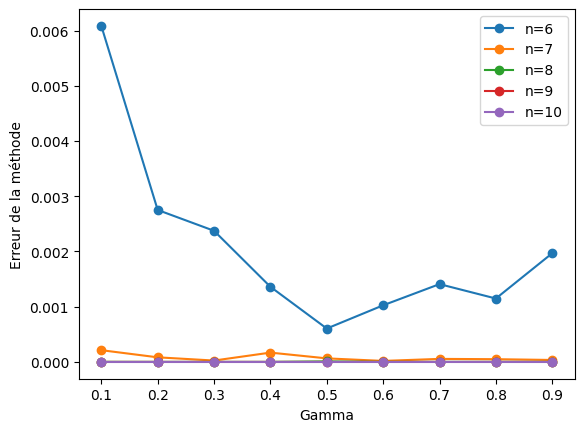

In [21]:
gammaValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def greedy_errors_weak(n):
    greedy_errors_weak_gamma = [weakgreedy(F1, gamma, n, 80)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 6,11):
    greedy_errors_weak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

### Résultat weak weak greedy:

Arrêt anticipé à l'étape 7 veuillez relancer une autre méthode
Arrêt anticipé à l'étape 7 veuillez relancer une autre méthode
Arrêt anticipé à l'étape 9 veuillez relancer une autre méthode
Arrêt anticipé à l'étape 7 veuillez relancer une autre méthode


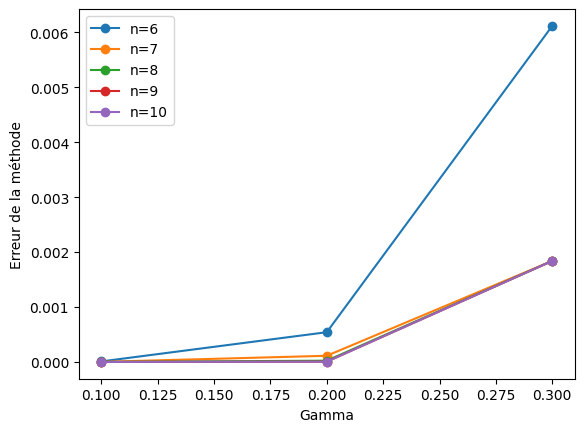

In [22]:
gammaValues = [0.1, 0.2, 0.3 ]
def greedy_errors_weakweak(n):
    greedy_errors_weak_gamma = [weakweakgreedy(F1, gamma, n)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 6,11):
    greedy_errors_weakweak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

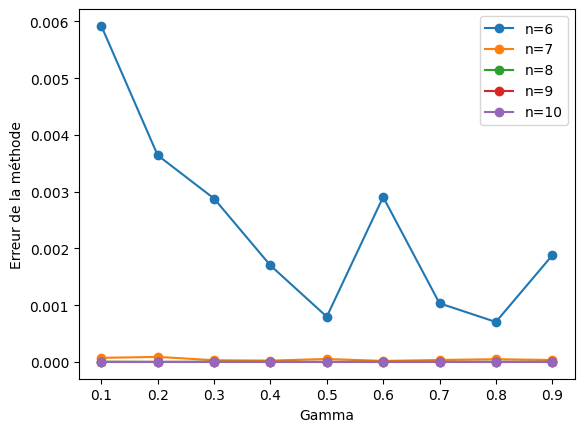

In [23]:
gammaValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def greedy_errors_weak(n):
    greedy_errors_weak_gamma = [weakgreedy(F1, gamma, n, 80)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 6,11):
    greedy_errors_weak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

### Comparaison Strong et Weak

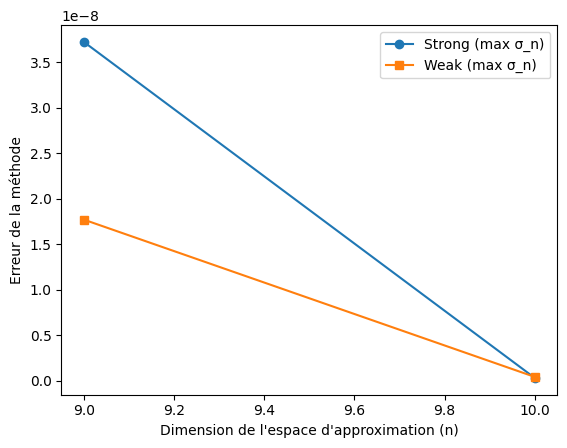

In [24]:
n_values = range(9, 11)

greedy_errors_strong = [stronggreedy(F1, n)[1][-1] for n in n_values]  
greedy_errors_weak = [weakgreedy(F1, 0.7, n, 100)[1][-1] for n in n_values]  

plt.plot(n_values, greedy_errors_strong, 'o-', label='Strong (max σ_n)')
plt.plot(n_values, greedy_errors_weak, 's-', label='Weak (max σ_n)')
plt.xlabel('Dimension de l\'espace d\'approximation (n)')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

### Comparaison des résultats entre Strong et PCA

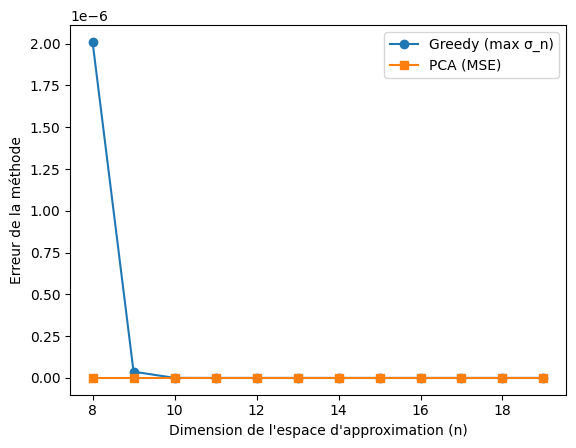

In [25]:
n_values = range(8, 20)

greedy_errors_strong = [stronggreedy(F1, n)[1][-1] for n in n_values] 
pca_errors = [pca_reduction(F1, n)[1] for n in n_values]  

plt.plot(n_values, greedy_errors_strong, 'o-', label='Greedy (max σ_n)')
plt.plot(n_values, pca_errors, 's-', label='PCA (MSE)')
plt.xlabel('Dimension de l\'espace d\'approximation (n)')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

In [26]:
#A faire comparer le temps d'execution des différentes méthodes puis le plot.

A faire introduire un dataset multidimentionnel plus compliquer pour jouer avec, et regarder ce qui est le plus optimal nottament regarder la perte L1 et L2. Elle devrait être plus grande.

In [27]:
pca_reduction(F1, 9)[1]

3.1150867263256435e-17

## Conclusion


La PCA reste meilleure, le strong meilleure que le weak, mais pas de beaucoup et donc autant prendre le gain de temps.

A faire faire le rapport.